EXERCÍCIO 1

In [ ]:
# Core
import seaborn as sns
import pandas as pd
import numpy as np

# Visual
import matplotlib.pyplot as plt
import graphviz
import pprint
import io
plt.rcParams['figure.figsize'] = [15, 7.5]
import plotly.express as px
import statsmodels.api as sm

from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
df = pd.read_csv('train.csv')

df.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Util

In [ ]:
#Inicialmente, seguiremos o código da aula:
train, test = train_test_split(df, test_size = 0.3, random_state= 7)

#Para tratar train e test ao mesmo tempo

df = pd.read_csv('train.csv')
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#log transform the target:
train["SalePrice"] = np.log1p(train["SalePrice"])
#test["SalePrice"] = np.log1p(test["SalePrice"])

#log transform skewed numeric features:
numeric_feats = all_data.dtypes[all_data.dtypes != "object"].index

skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
#Encontrar o que precisa ser normalizado


all_data[skewed_feats] = np.log1p(all_data[skewed_feats])
all_data = pd.get_dummies(all_data)

#filling NA's with the mean of the column:
all_data = all_data.fillna(all_data.mean())
#

#creating matrices for sklearn:
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y_train = train.SalePrice
y_test = test.SalePrice

In [ ]:
df.head

<bound method NDFrame.head of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0        1          60       RL         65.0     8450   Pave   NaN      Reg   
1        2          20       RL         80.0     9600   Pave   NaN      Reg   
2        3          60       RL         68.0    11250   Pave   NaN      IR1   
3        4          70       RL         60.0     9550   Pave   NaN      IR1   
4        5          60       RL         84.0    14260   Pave   NaN      IR1   
...    ...         ...      ...          ...      ...    ...   ...      ...   
1455  1456          60       RL         62.0     7917   Pave   NaN      Reg   
1456  1457          20       RL         85.0    13175   Pave   NaN      Reg   
1457  1458          70       RL         66.0     9042   Pave   NaN      Reg   
1458  1459          20       RL         68.0     9717   Pave   NaN      Reg   
1459  1460          20       RL         75.0     9937   Pave   NaN      Reg   

     LandContour Util

In [ ]:
def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    
    return mape

Modelos (para entender resultados antes do tratamento dos dados):

In [ ]:
#Rodaremos uma regressão linear:

import statsmodels.api as sm

X_all_lr = sm.add_constant( X_train, has_constant= 'add' )
X_all_lr_test = sm.add_constant( X_test, has_constant='add')

linear_reg = sm.OLS(y_train, X_all_lr)
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_all_lr_test)
print(linear_reg_fit.summary())

print('Mape')
print( mape( y_test, np.exp(linear_reg_pred)))

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1294: RuntimeWarning: invalid value encountered in true_divide
  return self.params / self.bse


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.959
Model:                            OLS   Adj. R-squared:                  0.946
Method:                 Least Squares   F-statistic:                     74.94
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        10:07:21   Log-Likelihood:                 1121.6
No. Observations:                1022   AIC:                            -1759.
Df Residuals:                     780   BIC:                            -566.3
Df Model:                         241                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.88

In [ ]:
linear_reg = LinearRegression()
linear_reg.fit(X_train[['GrLivArea']], y_train)
pred_linear = linear_reg.predict(X_test[['GrLivArea']])

mape( y_test, np.exp(pred_linear))

21.766435511474718

In [ ]:
#ridge
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train, y_train)
ridge_pred = ridge_reg.predict(X_test)

map( y_test, np.exp(ridge_pred) )


Visando diminuir a mape, vamos: Analisar as variáveis, preparar os dados, selecionar variáveis e apresentar os modelos:

**Análise das Variáveis**

In [ ]:
train, test = train_test_split(df, test_size=0.3, random_state = 7)

train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1022 entries, 680 to 175
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1022 non-null   int64  
 1   MSSubClass     1022 non-null   int64  
 2   MSZoning       1022 non-null   object 
 3   LotFrontage    834 non-null    float64
 4   LotArea        1022 non-null   int64  
 5   Street         1022 non-null   object 
 6   Alley          68 non-null     object 
 7   LotShape       1022 non-null   object 
 8   LandContour    1022 non-null   object 
 9   Utilities      1022 non-null   object 
 10  LotConfig      1022 non-null   object 
 11  LandSlope      1022 non-null   object 
 12  Neighborhood   1022 non-null   object 
 13  Condition1     1022 non-null   object 
 14  Condition2     1022 non-null   object 
 15  BldgType       1022 non-null   object 
 16  HouseStyle     1022 non-null   object 
 17  OverallQual    1022 non-null   int64  
 18  Overall

In [ ]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [ ]:
train.describe

<bound method NDFrame.describe of         Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
680    681         120       RL         50.0     8012   Pave   NaN      Reg   
1451  1452          20       RL         78.0     9262   Pave   NaN      Reg   
1196  1197          60       RL         58.0    14054   Pave   NaN      IR1   
1024  1025          20       RL          NaN    15498   Pave   NaN      IR1   
157    158          60       RL         92.0    12003   Pave   NaN      Reg   
...    ...         ...      ...          ...      ...    ...   ...      ...   
211    212          20       RL         83.0    10420   Pave   NaN      Reg   
502    503          20       RL         70.0     9170   Pave   NaN      Reg   
537    538          20       RL          NaN    12735   Pave   NaN      IR1   
1220  1221          20       RL         66.0     7800   Pave   NaN      IR1   
175    176          20       RL         84.0    12615   Pave   NaN      Reg   

     LandContour 

**Missing Values** 
- Identificação do valores missing 
- Tratamento desses valores

In [54]:
new = ['SalePrice'] + (train.columns.drop('SalePrice').tolist())
train = train[new]

train

,SalePrice,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
680,11.870607,681,4.795791,3.931826,8.988821,6,5,1980,1980,0.000000,...,0,0,0,1,0,0,0,0,1,0
1451,12.567555,1452,3.044522,4.369448,9.133783,8,5,2008,2009,5.273000,...,0,1,0,0,0,0,0,0,0,1
1196,12.297790,1197,4.110874,4.077537,9.550733,7,5,2006,2006,0.000000,...,0,1,0,0,0,0,0,0,0,1
1024,12.567241,1025,3.044522,4.278463,9.648531,8,6,1976,1976,0.000000,...,0,0,0,0,1,0,0,0,0,0
157,12.504327,158,4.110874,4.532599,9.392995,8,5,2009,2010,4.442651,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,12.133507,212,3.044522,4.430817,9.251578,6,5,2009,2009,0.000000,...,0,0,0,1,0,0,0,0,1,0
502,11.849405,503,3.044522,4.262680,9.123802,5,7,1965,1965,0.000000,...,0,0,0,1,0,0,0,0,1,0
537,11.619544,538,3.044522,4.278463,9.452188,4,5,1972,1972,0.000000,...,0,0,0,0,0,0,0,0,1,0
1220,11.652696,1221,3.044522,4.204693,8.962007,5,5,1964,1964,0.000000,...,0,0,0,1,1,0,0,0,0,0


In [16]:
total = train.isnull().sum().sort_values(ascending=False)

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(18) 

,Total,Percent
PoolQC,1018,0.996086
MiscFeature,987,0.965753
Alley,954,0.933464
Fence,825,0.807241
FireplaceQu,471,0.460861
LotFrontage,188,0.183953
GarageFinish,60,0.058708
GarageCond,60,0.058708
GarageType,60,0.058708
GarageYrBlt,60,0.058708


Antes de iniciar o tratamento dos valores nulos, rodaremos uma regressão para melhor entender a importância de cada variável (em especial, as variáveis que possuem outliers e valores nulos). Assim, decidiremos se dropar é uma opção ou não. 

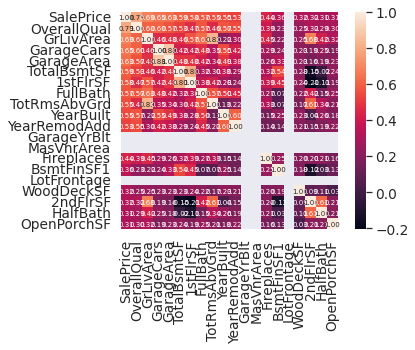

In [18]:
corrmat = train.corr()

k = 20
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 7}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Como algumas variávies que possuem missing values (ex. PoolQC, MiscFeature, Alley, Fence, FireplaceQu, Garages, Bsmt...) e que são usados em casos que só não se aplicam, podemos substituir NAs por "Inexistente". 

In [19]:
train[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu', 'MasVnrType']] = train[['PoolQC','MiscFeature','Alley','Fence','FireplaceQu', 'MasVnrType']].fillna("Inexistente")
train

test[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']] = test[['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'MasVnrType']].fillna("Inexistente")


In [20]:
train[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = train[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna("Inexistente")
test[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = test[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna("Inexistente")


In [21]:
train[['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']] = train[['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']].fillna(0)
test[['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']] = test[['GarageYrBlt', 'GarageArea', 'GarageCars', 'MasVnrArea']].fillna(0)

In [22]:
train[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = train[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna("Inexistente")
test[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = test[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna("Inexistente")


Agora, como LotFrontage também possui valores altos nulos, vamos utilizar o método de substituição pela média:

In [23]:
train_Lotfrontage_mean = train
test_Lotfrontage_mean = test

train_Lotfrontage_mean['LotFrontage'] = train_Lotfrontage_mean['LotFrontage'].fillna(train_Lotfrontage_mean['LotFrontage'].mean())
test_Lotfrontage_mean['LotFrontage'] = test_Lotfrontage_mean['LotFrontage'].fillna(test_Lotfrontage_mean['LotFrontage'].mean())

In [24]:
train.shape

(1022, 81)

In [25]:
total = train.isnull().sum().sort_values(ascending=False)

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head(18) 


,Total,Percent
SalePrice,0,0.0
HeatingQC,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0
BedroomAbvGr,0,0.0


Aqui, os valores nulos foram tratados

**Outliers**

In [26]:
#Definição dos limites - detecção dos outliers
n = 3

upper_limit = train['SalePrice'].mean() + n*train['SalePrice'].std()
lower_limit = train['SalePrice'].mean() - n*train['SalePrice'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)


Highest allowed 409923.5548187534
Lowest allowed -50679.81313577885


In [27]:
#Aplicação da regra de retirada desses outliers

train_trimmed = train[
    ( train['SalePrice'] < upper_limit ) & 

    ( train['SalePrice'] > lower_limit )
    ]

In [28]:
train_trimmed.shape

(1006, 81)

In [29]:
train_trimmed = train

(array([ 63., 382., 316., 149.,  65.,  23.,  15.,   4.,   2.,   3.]),
 array([ 34900.,  93910., 152920., 211930., 270940., 329950., 388960.,
        447970., 506980., 565990., 625000.]),
 <a list of 10 Patch objects>)

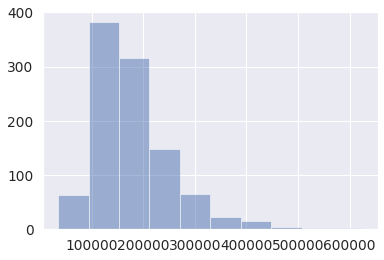

In [30]:
plt.hist(train_trimmed['SalePrice'], alpha=0.5, label='Trimmed')

**Normalização das distribuições** 
- Nesta etapa, identificaremos as variáveis que possuem distribuição distorcida e iremos normalizá-las.

In [31]:
#Identificação
numeric_feats = train.dtypes[train.dtypes != "object"].index

skewed_feats= train[numeric_feats].apply(lambda x: skew(x.dropna())) 
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index


skewed_feats

Index(['SalePrice', 'MSSubClass', 'LotFrontage', 'LotArea', 'MasVnrArea',
       'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal'],
      dtype='object')

In [32]:
#Normalização
train[skewed_feats] = np.log1p(train[skewed_feats])

In [33]:
test[skewed_feats] = np.log1p(test[skewed_feats])

Agora, vamos para a etapa final de preparação da base de dados: **Seleção das Variáveis**


In [34]:
#Tranformaremos as variáveis categóricas em dummies:

MoSold = train.MoSold
pd.get_dummies(MoSold)

MSSubClass = train.MSSubClass
pd.get_dummies(MSSubClass)

YrSold = train.YrSold
pd.get_dummies(YrSold)


,2006,2007,2008,2009,2010
680,0,0,0,0,1
1451,0,0,0,1,0
1196,1,0,0,0,0
1024,0,0,1,0,0
157,0,0,0,0,1
...,...,...,...,...,...
211,0,0,0,0,1
502,0,1,0,0,0
537,0,0,1,0,0
1220,1,0,0,0,0


In [35]:
train = pd.get_dummies(train)
train

,SalePrice,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
680,11.870607,681,4.795791,3.931826,8.988821,6,5,1980,1980,0.000000,...,0,0,0,1,0,0,0,0,1,0
1451,12.567555,1452,3.044522,4.369448,9.133783,8,5,2008,2009,5.273000,...,0,1,0,0,0,0,0,0,0,1
1196,12.297790,1197,4.110874,4.077537,9.550733,7,5,2006,2006,0.000000,...,0,1,0,0,0,0,0,0,0,1
1024,12.567241,1025,3.044522,4.278463,9.648531,8,6,1976,1976,0.000000,...,0,0,0,0,1,0,0,0,0,0
157,12.504327,158,4.110874,4.532599,9.392995,8,5,2009,2010,4.442651,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,12.133507,212,3.044522,4.430817,9.251578,6,5,2009,2009,0.000000,...,0,0,0,1,0,0,0,0,1,0
502,11.849405,503,3.044522,4.262680,9.123802,5,7,1965,1965,0.000000,...,0,0,0,1,0,0,0,0,1,0
537,11.619544,538,3.044522,4.278463,9.452188,4,5,1972,1972,0.000000,...,0,0,0,0,0,0,0,0,1,0
1220,11.652696,1221,3.044522,4.204693,8.962007,5,5,1964,1964,0.000000,...,0,0,0,1,1,0,0,0,0,0


In [36]:
test = pd.get_dummies(test)
test

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,SaleType_ConLD,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
606,607,3.044522,4.418841,9.430680,5,5,1996,1996,0.00000,6.597146,...,0,0,0,1,0,0,0,0,1,0
1210,1211,4.110874,4.262680,9.325364,6,5,1992,1992,0.00000,0.000000,...,0,0,0,1,0,0,0,0,1,0
492,493,4.110874,4.663439,9.653679,6,5,2006,2006,0.00000,0.000000,...,0,1,0,0,0,0,0,0,0,1
410,411,3.044522,4.234107,9.166597,5,3,1958,1958,0.00000,0.000000,...,0,0,0,0,1,0,0,0,0,0
396,397,3.044522,4.110874,8.881975,5,5,1972,1972,0.00000,6.656727,...,0,0,0,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
704,705,3.044522,4.262680,9.036106,7,5,2004,2005,4.70048,6.569481,...,0,0,0,1,0,0,0,0,1,0
513,514,3.044522,4.276666,9.125654,6,5,1983,1983,0.00000,5.820083,...,0,0,0,1,0,0,0,0,1,0
674,675,3.044522,4.394449,9.127067,6,6,1965,1965,0.00000,6.794587,...,0,0,0,1,0,0,0,0,1,0
1449,1450,5.198497,3.091042,7.335634,5,7,1970,1970,0.00000,6.317165,...,0,0,0,1,1,0,0,0,0,0


In [37]:
train.info

<bound method DataFrame.info of       SalePrice    Id  MSSubClass  LotFrontage   LotArea  OverallQual  \
680   11.870607   681    4.795791     3.931826  8.988821            6   
1451  12.567555  1452    3.044522     4.369448  9.133783            8   
1196  12.297790  1197    4.110874     4.077537  9.550733            7   
1024  12.567241  1025    3.044522     4.278463  9.648531            8   
157   12.504327   158    4.110874     4.532599  9.392995            8   
...         ...   ...         ...          ...       ...          ...   
211   12.133507   212    3.044522     4.430817  9.251578            6   
502   11.849405   503    3.044522     4.262680  9.123802            5   
537   11.619544   538    3.044522     4.278463  9.452188            4   
1220  11.652696  1221    3.044522     4.204693  8.962007            5   
175   12.400821   176    3.044522     4.442651  9.442721            6   

      OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  ...  SaleType_ConLw  \
680         

In [38]:
#Droparemos o y e Id, como forma de avaliar somente as features (feats)
X_train_feats = train.drop(['Id','SalePrice'], axis=1)
X_test_feats = test.drop(['Id','SalePrice'], axis = 1)

y_train = train.SalePrice
y_test = test.SalePrice

features = X_train.columns.values

feats = pd.concat([X_train_feats, X_test_feats]).reset_index(drop=True)

In [39]:
def label_encode(feats):
    X = feats.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

In [53]:
#Agora, como forma de encontrar em melhores features para serem usadas no modelo, rodaremos o comanda SelectKBest: 


from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  mutual_info_regression


def make_mi_scores(X_train, y_train, discrete_features):
    mi_scores = mutual_info_regression(X_train, y_train, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


selected = SelectKBest(score_func= mutual_info_regression, k=10)
z = selected.fit_transform(X_train,y_train)

filter = selected.get_support()

#Encontrando as melhores features
print("10 best features", z.shape) 
print(features[filter])

10 best features (1022, 10)
['MSSubClass' 'OverallQual' 'YearBuilt' 'TotalBsmtSF' '1stFlrSF'
 'GrLivArea' 'FullBath' 'GarageYrBlt' 'GarageCars' 'GarageArea']


In [43]:
#Agora, como forma de encontrar as melhores features para serem usadas no modelo, rodaremos o comanda SelectKBest:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import  mutual_info_regression

selected = SelectKBest(score_func= mutual_info_regression, k=5)
z = selected.fit_transform(X_train,y_train)

filter = selected.get_support()

#Encontrando as melhores features
print("5 best features", z.shape) 
print(features[filter])

5 best features (1022, 5)
['OverallQual' 'TotalBsmtSF' 'GrLivArea' 'GarageCars' 'GarageArea']


In [47]:
#Agora, como forma de avaliar diferentes resultados rodando o modelo, rodaremos a regressão que mostra as relações 
#entre as variáveis e o Y, para selecionar as 7 maiores variáveis correlacionadas e usar no modelo:

corr = train.corr().sort_values(
    by = "SalePrice",  ascending=False)
corr.head(20)

,SalePrice,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
SalePrice,1.000000,-0.010982,-0.000850,0.337859,0.400758,0.816341,-0.021537,0.600486,0.578267,0.420763,...,-0.044019,0.326479,-0.025525,-0.217149,-0.168530,-0.077285,-0.031756,-0.031568,-0.080247,0.319111
OverallQual,0.816341,-0.026045,0.092642,0.205272,0.188825,1.000000,-0.074927,0.571425,0.550075,0.423653,...,-0.022838,0.317683,-0.065272,-0.216655,-0.123797,-0.054019,-0.044864,0.000786,-0.115230,0.311581
GrLivArea,0.727793,-0.007780,0.219732,0.303961,0.382853,0.622305,-0.100810,0.253150,0.323545,0.293825,...,-0.026441,0.177869,-0.033574,-0.133886,-0.070982,-0.035315,0.040072,0.014695,-0.081487,0.169377
GarageCars,0.686206,0.007010,0.000957,0.268316,0.282831,0.599812,-0.152268,0.547805,0.423752,0.395195,...,-0.052014,0.267366,-0.074250,-0.177091,-0.111195,-0.103061,0.059413,-0.011435,-0.105859,0.261280
GarageArea,0.661065,0.008716,-0.064446,0.315477,0.340063,0.566694,-0.107974,0.486335,0.383426,0.384688,...,-0.049108,0.268446,-0.068840,-0.190593,-0.095610,-0.099786,0.016842,-0.025186,-0.103922,0.265890
FullBath,0.606570,-0.005994,0.201563,0.141018,0.167366,0.572269,-0.191141,0.497113,0.445113,0.281099,...,-0.020530,0.245827,-0.004895,-0.181058,-0.082806,-0.022479,-0.002891,0.014786,-0.110907,0.236855
YearBuilt,0.600486,-0.025258,0.018857,0.081471,0.038435,0.571425,-0.356280,1.000000,0.598945,0.423269,...,-0.026394,0.335956,0.004232,-0.234507,-0.117105,-0.063764,-0.015227,-0.030614,-0.129895,0.331315
1stFlrSF,0.592607,0.011380,-0.305992,0.406423,0.462382,0.450858,-0.124529,0.279922,0.233277,0.345468,...,-0.058659,0.188880,0.001520,-0.142464,-0.070191,-0.048789,0.084713,0.053620,-0.118746,0.189155
YearRemodAdd,0.578267,-0.031490,0.075012,0.066358,0.043191,0.550075,0.070708,0.598945,1.000000,0.227414,...,-0.045475,0.311121,-0.022951,-0.174821,-0.159534,-0.045137,-0.024099,-0.031902,-0.084373,0.307034
TotRmsAbvGrd,0.555722,0.011536,0.180563,0.295646,0.346789,0.457404,-0.053419,0.130810,0.218701,0.226643,...,-0.041349,0.172295,-0.001674,-0.138161,-0.046909,0.014586,0.080376,0.038735,-0.119135,0.163150


**Modelos**
- Agora com a seleção das variáveis realizada, concluiremos rodando os modelos e avaliando os novos resultados.

In [44]:
#Tentaremos com as 5 melhores variáveis: 
import statsmodels.api as sm
X_test_eng = X_test[['OverallQual','TotalBsmtSF','GrLivArea','GarageCars','GarageArea']]
X_train_eng = X_train[['OverallQual','TotalBsmtSF','GrLivArea','GarageCars','GarageArea']]


X_all_lr = sm.add_constant( X_train_eng, has_constant= 'add' )
X_all_lr_test = sm.add_constant( X_test_eng, has_constant='add'  )

linear_reg = sm.OLS(y_train, X_all_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_all_lr_test)
print(linear_reg_fit.summary())

#Definindo a mape

def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    
    return mape

print('Mape')
print( mape( y_test, np.exp(linear_reg_pred)) )

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.794
Method:                 Least Squares   F-statistic:                     789.1
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        11:10:29   Log-Likelihood:                 304.69
No. Observations:                1022   AIC:                            -597.4
Df Residuals:                    1016   BIC:                            -567.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           8.1509      0.145     56.277      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [41]:
#Regressão Linear (com as 10 melhores variáveis):

import statsmodels.api as sm
X_test_eng = X_test[['MSSubClass', 'OverallQual','YearBuilt','TotalBsmtSF','1stFlrSF', 'GrLivArea', 'FullBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']]
X_train_eng = X_train[['MSSubClass', 'OverallQual','YearBuilt','TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']]


X_all_lr = sm.add_constant( X_train_eng, has_constant= 'add' )
X_all_lr_test = sm.add_constant( X_test_eng, has_constant='add'  )

linear_reg = sm.OLS(y_train, X_all_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_all_lr_test)
print(linear_reg_fit.summary())

#Definindo a mape

def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    
    return mape

print('Mape')
print( mape( y_test, np.exp(linear_reg_pred)) )


                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.832
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     502.2
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        11:02:41   Log-Likelihood:                 407.10
No. Observations:                1022   AIC:                            -792.2
Df Residuals:                    1011   BIC:                            -738.0
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           2.3139      0.634      3.648      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [49]:
#Regressão Linear (com as 7 variáveis que apresentam as maiores correlações):

import statsmodels.api as sm
X_test_eng = X_test[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt', '1stFlrSF']]
X_train_eng = X_train[['OverallQual', 'GrLivArea', 'GarageCars', 'GarageArea', 'FullBath', 'YearBuilt', '1stFlrSF']]


X_all_lr = sm.add_constant( X_train_eng, has_constant= 'add' )
X_all_lr_test = sm.add_constant( X_test_eng, has_constant='add'  )

linear_reg = sm.OLS(y_train, X_all_lr )
linear_reg_fit  = linear_reg.fit()
linear_reg_pred = linear_reg_fit.predict(X_all_lr_test)
print(linear_reg_fit.summary())

#Definindo a mape

def mape(Y_actual, Y_Predicted):
    mape = np.mean(np.abs( Y_actual - Y_Predicted)/Y_actual)*100
    
    return mape

print('Mape')
print( mape( y_test, np.exp(linear_reg_pred)) )

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.822
Model:                            OLS   Adj. R-squared:                  0.820
Method:                 Least Squares   F-statistic:                     667.4
Date:                Wed, 25 May 2022   Prob (F-statistic):               0.00
Time:                        11:53:52   Log-Likelihood:                 375.34
No. Observations:                1022   AIC:                            -734.7
Df Residuals:                    1014   BIC:                            -695.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.9336      0.546      3.543      

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


Complementando com Ridge e Elastic:

In [92]:
#Ridge Regression:
ridge_reg = Ridge(alpha = 0.5)
ridge_reg.fit(X_train_eng, y_train)
ridge_pred = ridge_reg.predict(X_test_eng)

#MAPE
mape( y_test, np.exp(ridge_pred) )

1483398.6000961678

In [93]:
#Elastic Net:
model_ElasticNet = ElasticNetCV(
    l1_ratio = 0.5,
    alphas = [1, 0.1, 0.001, 0.0005]).fit(X_train_eng, y_train)

elastic_pred = model_ElasticNet.predict(X_test_eng)

#MAPE
mape( y_test, elastic_pred)

1.032945015862784

EXERCÍCIO 2

Data Prep



*   Primeiro, busquei entender as variáveis (seus comportamentos) e juntei as duas bases. 
*   Em seguida, trataremos os dados em relação a seus valores nulos, duplicados e outliers, como forma de melhorar a base 




In [56]:
# Core
import pandas as pd
import numpy as np

# Visual
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 7.5]

import graphviz
import pprint
import seaborn as sns


# Sklearn
from sklearn import tree as sk_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import median_absolute_error, mean_absolute_error, r2_score, max_error, explained_variance_score
from sklearn.model_selection import train_test_split

from scipy.stats import skew
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV, ElasticNet, LassoCV, ElasticNetCV
from sklearn.model_selection import train_test_split


In [57]:
df1 = pd.read_csv('student-mat.csv')

df2 = pd.read_csv('student-por.csv')

df = pd.concat([df1, df2])



In [58]:
df1.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [59]:
df2.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,4,0,11,11
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,2,9,11,11
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,6,12,13,12
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,0,14,14,14
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,0,11,13,13


In [60]:
df.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [61]:
df = df.drop(['G1','G2'], axis=1) 

In [62]:
train, test = train_test_split(df, test_size=0.3)

train.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,G3
93,GP,F,16,U,GT3,T,4,2,teacher,services,...,yes,no,5,3,3,1,1,1,0,10
429,MS,M,16,R,LE3,A,4,4,at_home,other,...,no,no,5,3,2,1,3,2,5,11
14,GP,M,15,U,GT3,A,2,2,other,other,...,yes,yes,4,5,2,1,1,3,0,16
122,GP,F,16,U,LE3,T,2,4,other,health,...,yes,yes,4,2,2,1,2,5,2,13
95,GP,F,15,R,GT3,T,1,1,at_home,other,...,yes,no,3,1,2,1,1,1,2,10


In [63]:
train.columns

Index(['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu',
       'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime',
       'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
       'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc',
       'Walc', 'health', 'absences', 'G3'],
      dtype='object')

In [64]:
train.describe()

,age,Medu,Fedu,traveltime,studytime,failures,famrel,freetime,goout,Dalc,Walc,health,absences,G3
count,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000,730.000000
mean,16.690411,2.630137,2.378082,1.528767,1.961644,0.253425,3.943836,3.204110,3.154795,1.490411,2.297260,3.547945,4.297260,11.393151
std,1.249435,1.109961,1.110895,0.748016,0.808838,0.639483,0.919755,1.032123,1.153220,0.901479,1.276835,1.431960,6.130776,3.875314
min,15.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,16.000000,2.000000,1.000000,1.000000,1.000000,0.000000,4.000000,3.000000,2.000000,1.000000,1.000000,3.000000,0.000000,10.000000
50%,17.000000,3.000000,2.000000,1.000000,2.000000,0.000000,4.000000,3.000000,3.000000,1.000000,2.000000,4.000000,2.000000,11.000000
75%,18.000000,4.000000,3.000000,2.000000,2.000000,0.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,6.000000,14.000000
max,22.000000,4.000000,4.000000,4.000000,4.000000,3.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,75.000000,20.000000


In [65]:
train.shape

(730, 31)

Aqui, pontuamos um indicativo de que a base possui outliers olhando o comportamento da linha da média.

In [66]:
train.dtypes

school        object
sex           object
age            int64
address       object
famsize       object
Pstatus       object
Medu           int64
Fedu           int64
Mjob          object
Fjob          object
reason        object
guardian      object
traveltime     int64
studytime      int64
failures       int64
schoolsup     object
famsup        object
paid          object
activities    object
nursery       object
higher        object
internet      object
romantic      object
famrel         int64
freetime       int64
goout          int64
Dalc           int64
Walc           int64
health         int64
absences       int64
G3             int64
dtype: object

Missing Data, Valores Repetidos e Outliers

In [67]:
total = train.isnull().sum().sort_values(ascending=False)

percent = (train.isnull().sum()/train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat(
     [total, percent],
      axis=1,
      keys=['Total', 'Percent'])
      
missing_data.head() 

,Total,Percent
school,0,0.0
famsup,0,0.0
absences,0,0.0
health,0,0.0
Walc,0,0.0


Nesse caso, não temos missing values.

Agora, analisaremos a presença de observações repetidas, e caso existam, droparemos

In [68]:
train.duplicated()

train.duplicated().sum()

3

In [69]:
train2 = train.drop_duplicates(keep = False)

train2.shape

(724, 31)

In [70]:
train2 = train

Em seguida, proseguiremos a análise em busca de identificar os outliers e retirar outliers

In [71]:
#Primeiro, definiremos a regra (considerando G3 como nossa variável dependente): 

n = 3

upper_limit = train['G3'].mean() + n*train['G3'].std()
lower_limit = train['G3'].mean() - n*train['G3'].std()

print("Highest allowed", upper_limit)
print("Lowest allowed", lower_limit)

#Código retirado da aula

Highest allowed 23.01909323449439
Lowest allowed -0.23279186463137513


In [72]:
train_trimmed = train[
    ( train['G3'] < upper_limit ) & 

    ( train['G3'] > lower_limit )
    ]

In [73]:
#Como absences apresentou uma média muito maior que as demais, buscamos dropar os outliers presentes na feature, de forma a evitar
#que os mesmos atrapalhem o modelo:

train_trimmed = train[train['absences'] < upper_limit]


In [74]:
train_trimmed.shape

(722, 31)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


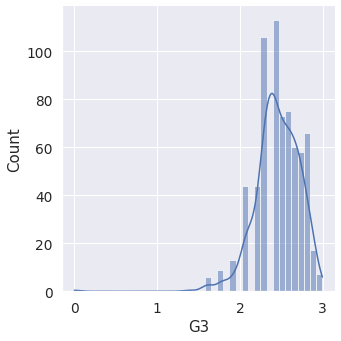

In [75]:
sns.displot( np.log( train['G3']), kde=True);

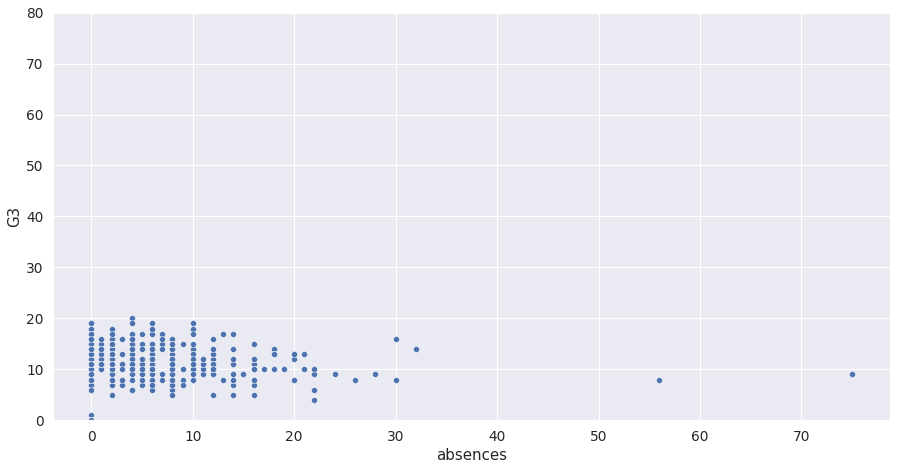

In [76]:
var = 'absences'
data = pd.concat([train['G3'], train[var]], axis=1)
fig = sns.scatterplot(x=var, y="G3", data=data)
fig.axis(ymin=0, ymax=80);

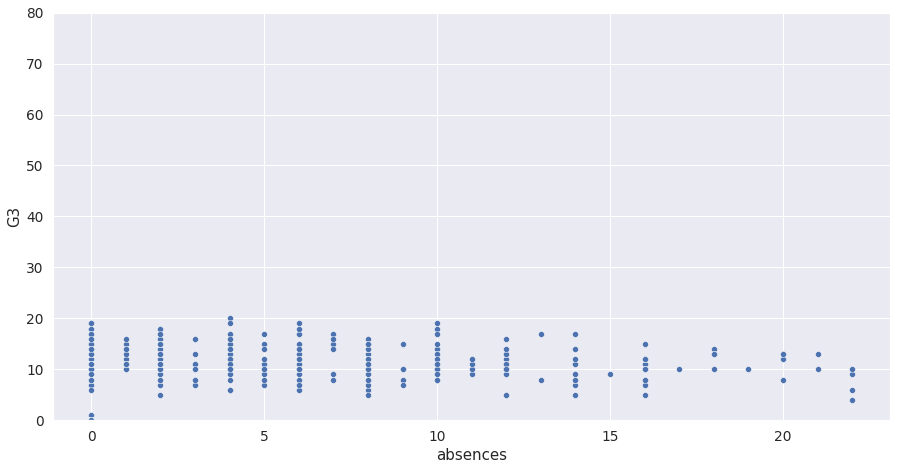

In [77]:
#Comparando distribuição após a retirada de outliers
var = 'absences'
data = pd.concat([train_trimmed['G3'], train_trimmed[var]], axis=1)
fig = sns.scatterplot(x=var, y="G3", data=data)
fig.axis(ymin=0, ymax=80);

In [78]:
train_trimmed = train

In [79]:
#Normalizando:
from scipy.stats import zscore
train['G3'] = zscore(train['G3'])

**Quais são os principais determinantes para a nota observada?**

Aqui, buscaremos responder analisando a correlação entre as variáveis independentes e a dependente - além de uma análise qualitativa referente ao significado de cada variável. 

De cara, notamos que o comportamento do tempo de estudo (studytime) e das faltas (absences) refletem o desempenho do aluno, logo, suas notas(G3). Dalc também se torna importante, já que representa o consumo de alcool durante a semana - que é a análise proposta inicialmente (o quanto esse consumo impacta a nota dos alunos). 

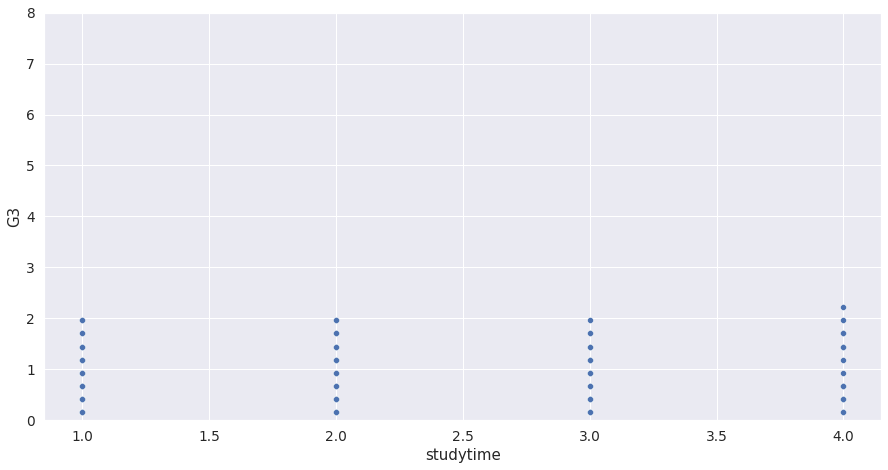

In [80]:
var = 'studytime'
data = pd.concat([train['G3'], train[var]], axis=1)
fig = sns.scatterplot(x=var, y="G3", data=data)
fig.axis(ymin=0, ymax=8);

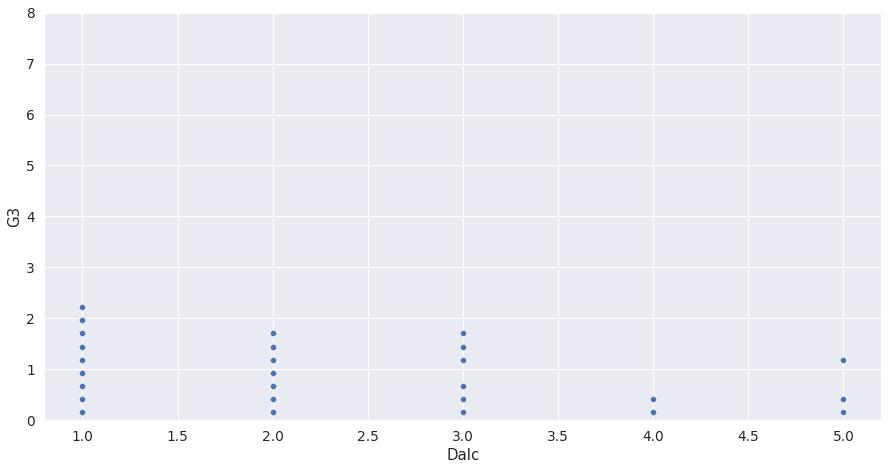

In [81]:
var = 'Dalc'
data = pd.concat([train['G3'], train[var]], axis=1)
fig = sns.scatterplot(x=var, y="G3", data=data)
fig.axis(ymin=0, ymax=8);

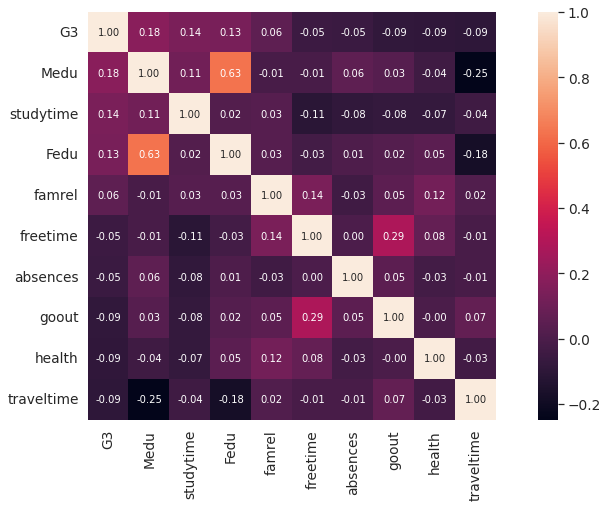

In [82]:
#Rodaremos a correlação das variáveis de modo a entender seus pesos em G3:
corrmat = train.corr()

k = 10
cols = corrmat.nlargest(k, 'G3')['G3'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [83]:
train['Dalc'].corr(train['G3'])

-0.11220000038532327

In [84]:
train['Walc'].corr(train['G3'])

-0.10321426915878182

Observando as correlações apresentadas e as descrições de cada variável, selecionaremos algumas variáveis que possuem impacto sobre a nota para rodar uma regressão linear:

In [85]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm

X = train[["Medu", "Fedu", "studytime", "absences", "Dalc", "Walc"]]
y = train["G3"]
X = sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X)
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     7.487
Date:                Wed, 25 May 2022   Prob (F-statistic):           8.46e-08
Time:                        12:45:06   Log-Likelihood:                -1013.8
No. Observations:                 730   AIC:                             2042.
Df Residuals:                     723   BIC:                             2074.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4812      0.157     -3.068      0.002      -0.789      -0.173
Medu           0.1311      0.043      3.080      0.002       0.048       0.215
Fedu           0.0351      0.042      0.833      0.405      -0.048       0.118
studytime      0.1251      0.046      2.703      0.007       0.034       0.216
absences      -0.0066      0.006     -1.108      0.268      -0.018       0.005
Dalc          -0.0722      0.052     -1.396      0.163      -0.174       0.029
Walc          -0.0245      0.037     -0.665      0.506      -0.097       0.048
==============================================================================
Omnibus:                      157.403   Durbin-Watson:                   2.043
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              332.429
Skew:                          -1.187   Prob(JB):                     6.51e-73
Kurtosis:                       5.301   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [86]:
X = train[["Medu", "Fedu", "studytime", "absences", "Dalc", "traveltime", "famrel"]]
y = train["G3"]
X = sm.add_constant(X)
model = sm.OLS(y.astype(float), X.astype(float)).fit()
predictions = model.predict(X)
model.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     G3   R-squared:                       0.062
Model:                            OLS   Adj. R-squared:                  0.053
Method:                 Least Squares   F-statistic:                     6.808
Date:                Wed, 25 May 2022   Prob (F-statistic):           7.61e-08
Time:                        12:45:09   Log-Likelihood:                -1012.5
No. Observations:                 730   AIC:                             2041.
Df Residuals:                     722   BIC:                             2078.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.6263      0.234     -2.678      0.008      -1.085      -0.167
Medu           0.1263      0.043      2.926      0.004       0.042       0.211
Fedu           0.0295      0.042      0.701      0.484      -0.053       0.112
studytime      0.1275      0.046      2.783      0.006       0.038       0.218
absences      -0.0067      0.006     -1.127      0.260      -0.018       0.005
Dalc          -0.0864      0.041     -2.096      0.036      -0.167      -0.005
traveltime    -0.0549      0.050     -1.097      0.273      -0.153       0.043
famrel         0.0546      0.039      1.388      0.166      -0.023       0.132
==============================================================================
Omnibus:                      154.532   Durbin-Watson:                   2.054
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              322.320
Skew:                          -1.172   Prob(JB):                     1.02e-70
Kurtosis:                       5.259   Cond. No.                         57.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Resultados: 

- Notamos que o consumo de alcool e tempo de translado até a escola (traveltime) afetam a variável dependente negativamente. O que faz sentido, visto que as notas são impactadas negativamente pelas escolhas dos alunos (consumo de alcool) e pelo tempo de translado, já que são duas variáveis que impactam tanto a qualidade como o tempo de estudo dos alunos. 
- Ademais, notamos que a educação dos pais, o tempo de estudos do aluno e a qualidade das relações familiares impactam positivamente seu desempenho na escola. 
- Pontuamos que o nível de escolaridade da mãe possue um peso maior em relação a escolaridade do pai. E que a escolaridade da mãe, o tempo de estudo do aluno e o consumo de alcool durante a semana são variáveis de maior impacto sobre o rendimento do aluno. 

Notamos que ao rodar a regressão com Dalc e Walc juntas, seus impactos foram diminuidos, isso ocorre devido ao alto nível de correlação entre as duas variáveis. Logo, separando podemos notar a relação direta entre o consumo de alcool (Walc ou Dalc) e G3. 

In [87]:
train['Dalc'].corr(train['G3'])

-0.11220000038532327

In [88]:
train['Walc'].corr(train['G3'])

-0.10321426915878182

In [89]:
train['Walc'].corr(train['Dalc'])

0.6275478852950445

Notamos que ambos os níveis de consumo (Dias de semana e Finais de Semana) impactam negativamente a nota dos alunos. Supreendentemente, consumo de alcool nos finais de semana apresentaram uma relação maior com a nota do que consumo em dias de semana. 
Como forma de melhorar a identificação desses impactos, uma sugestão seria especificar os níveis de consumo, por exemplo, não só especificar quando o aluno bebe, mas sim quanto ele bebe. Acreditamos que essa especificação poderia nos fornecer uma análise mais robusta a cerca dos reais impactos da bebida nas notas. 